# Time series analysis using data from the Brazilian stock market 

**Library imports**

In [18]:
from pandas_datareader import data as pdr
import yfinance as yf
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import warnings
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot

**Disabling warnings**

In [19]:
warnings.filterwarnings("ignore")

**Reading the data**

The analysis was performed with data from four of the biggest banks in Brazil. The stocks' data comprehend a period of two years (from 05/18/2021 to 05/18/2023).  

In [20]:
yf.pdr_override()

y_symbols = ['SANB11.SA', 'BBAS3.SA', 'BBDC4.SA', 'ITUB4.SA']

enddate = datetime.datetime.strptime("18/05/2023", "%d/%m/%Y")
startdate = enddate - datetime.timedelta(days=365*2)
data = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)

data.head(4)

[*********************100%***********************]  4 of 4 completed


Adj Close                                       Close             \
             BBAS3.SA   BBDC4.SA   ITUB4.SA  SANB11.SA   BBAS3.SA   BBDC4.SA   
Date                                                                           
2021-05-18  27.624224  20.709862  26.791794  34.234943  32.150002  23.090908   
2021-05-19  28.096798  20.848473  26.986341  35.408619  32.700001  23.245455   
2021-05-20  28.182718  21.044157  27.134563  35.218758  32.799999  23.463636   
2021-05-21  28.423309  21.141996  27.264259  35.408619  33.080002  23.572727   

                                       High             ...        Low  \
             ITUB4.SA  SANB11.SA   BBAS3.SA   BBDC4.SA  ...   ITUB4.SA   
Date                                                    ...              
2021-05-18  28.920000  39.669998  32.369999  23.136362  ...  28.680000   
2021-05-19  29.129999  41.029999  32.799999  23.245455  ...  28.200001   
2021-05-20  29.290001  40.810001  33.000000  23.463636  ...  29.059999   
2021-05-21  29.430000  41.029999  33.220001  23.709089  ...  28.940001   

                            Open                                     Volume  \
            SANB11.SA   BBAS3.SA   BBDC4.SA   ITUB4.SA  SANB11.SA  BBAS3.SA   
Date                                                                          
2021-05-18  39.090000  31.709999  22.645454  28.799999  39.200001  14836600   
2021-05-19  39.299999  31.799999  22.854546  28.530001  39.400002  14952800   
2021-05-20  40.720001  32.750000  23.181818  29.190001  41.150002  17411700   
2021-05-21  40.330002  33.000000  23.400000  29.330000  40.799999  14726800   

                                           
            BBDC4.SA  ITUB4.SA  SANB11.SA  
Date                                       
2021-05-18  47018290  26439800  1298000.0  
2021-05-19  31737860  26461500  2739600.0  
2021-05-20  35715570  32111400  1586700.0  
2021-05-21  60487790  27919700   876900.0  

[4 rows x 24 columns]

**Selecting feature to analyze**

The selected feature was the adjusted closing price ('Adj Close'), which reflects the daily price of the analyzed stock after the application of corporate actions, such as splits and dividend distribution.  

In [21]:
adj_close = data['Adj Close'].reset_index()
adj_close = adj_close.dropna()
adj_close.head()

,Date,BBAS3.SA,BBDC4.SA,ITUB4.SA,SANB11.SA
0,2021-05-18,27.624224,20.709862,26.791794,34.234943
1,2021-05-19,28.096798,20.848473,26.986341,35.408619
2,2021-05-20,28.182718,21.044157,27.134563,35.218758
3,2021-05-21,28.423309,21.141996,27.264259,35.408619
4,2021-05-24,28.609903,21.084923,27.190147,35.106567


**EDA (Exploratory Data Analysis)**

Calculating stock prices' correlations and value distributions:

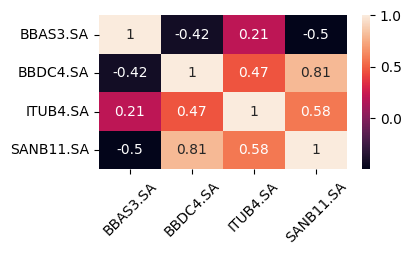

In [22]:
corr_matrix = adj_close.drop('Date', axis=1).corr()

plt.figure(figsize=(4,2))
sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=45)
plt.show()

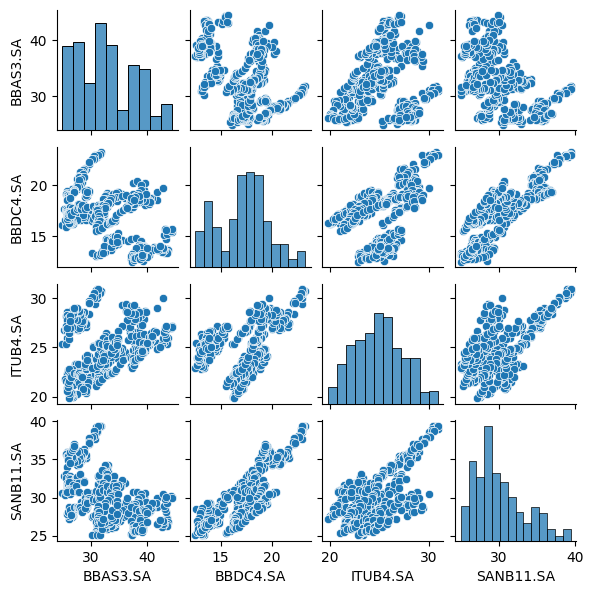

In [23]:
sns.pairplot(adj_close, height=1.5)
plt.show()

Time series plots - moving average (30 and 90 days) and exponential smoothing:

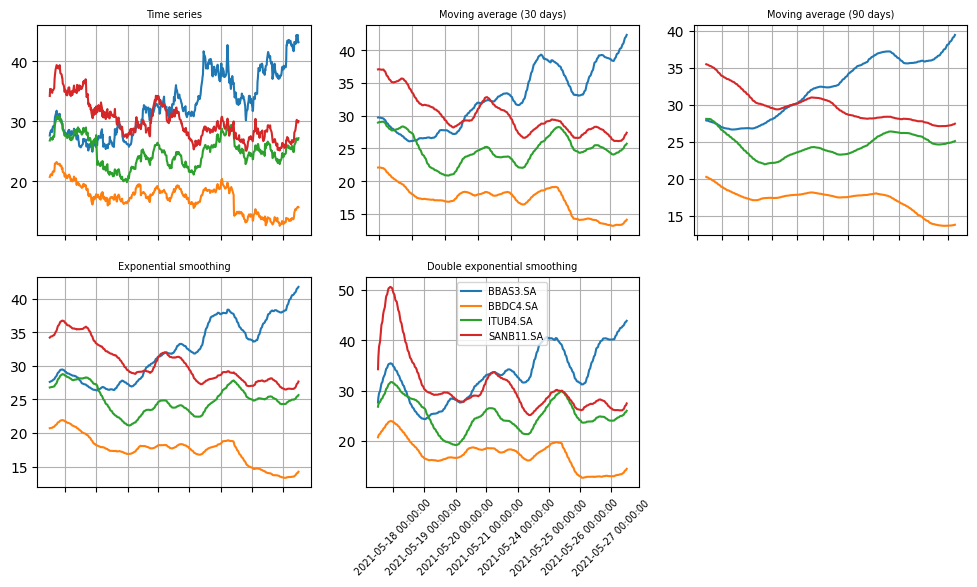

In [24]:
tickers = adj_close.drop('Date', axis=1).columns

fig  = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(231)

for i in tickers:
        ax1.plot(adj_close['Date'], adj_close[i])
ax1.grid()
ax1.set_xticklabels(labels=[])
ax1.set_title('Time series', fontsize=7)

ax2 = fig.add_subplot(232)

for i in tickers:
        ax2.plot(adj_close['Date'], adj_close[i].rolling(30).mean())
ax2.grid()
ax2.set_xticklabels(labels=[])
ax2.set_title('Moving average (30 days)', fontsize=7)

ax3 = fig.add_subplot(233)

for i in tickers:
        ax3.plot(adj_close['Date'], adj_close[i].rolling(90).mean())
ax3.grid()
ax3.set_xticklabels(labels=[])
ax3.set_title('Moving average (90 days)', fontsize=7)

def exp_smooth(series, alpha):
  result = [series[0]] 
  for n in range(1, len(series)):
    result.append(alpha * series.iloc[n] + (1 - alpha) * result[n-1])
  return result

ax4 = fig.add_subplot(234)

for i in tickers:
      ax4.plot(adj_close['Date'], exp_smooth(adj_close[i], 0.05))
ax4.grid()
ax4.set_xticklabels(labels=[])
ax4.set_title('Exponential smoothing', fontsize=7)

def double_exp_smooth(series, alpha, beta):
  result = [series[0]]
  for n in range(1, len(series)):
      if n == 1:
          level, trend = series[0], series[1] - series[0]
      if n >= len(series): 
          value = result[-1]
      else:
          value = series.iloc[n]
      last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
      trend = beta * (level - last_level) + (1 - beta) * trend
      result.append(level + trend)
  return result

ax5 = fig.add_subplot(235)

for i in tickers:
      ax5.plot(adj_close['Date'], double_exp_smooth(adj_close[i], 0.05, 0.05))
ax5.grid()
ax5.set_xticklabels(labels=adj_close['Date'], rotation=45, fontsize=7)
ax5.set_title('Double exponential smoothing', fontsize=7)

plt.legend(tickers, fontsize=7)
plt.show()


**Analyzing daily gains/losses**

We perform here a quick analysis of daily gains/losses using information from the percentual change on a stock's price between subsequent days. The expected return is derived from the mean of the percentual change and the risk, from its standard deviation.

In [25]:
adj_close_pct_change = adj_close.set_index('Date').pct_change().dropna()

adj_close_pct_change.head()

,BBAS3.SA,BBDC4.SA,ITUB4.SA,SANB11.SA
Date,,,,
2021-05-19,0.017107,0.006693,0.007261,0.034283
2021-05-20,0.003058,0.009386,0.005492,-0.005362
2021-05-21,0.008537,0.004649,0.004780,0.005391
2021-05-24,0.006565,-0.002700,-0.002718,-0.008530
2021-05-25,-0.013382,-0.005027,-0.010281,-0.010079


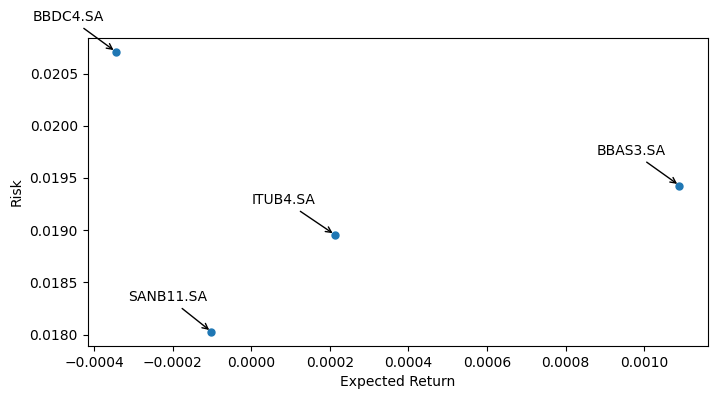

In [26]:
plt.figure(figsize=(8,4))

plt.scatter(adj_close_pct_change.mean(), adj_close_pct_change.std(), s=25)

plt.xlabel('Expected Return')
plt.ylabel('Risk')
for label,x,y in zip(adj_close_pct_change.columns,
                     adj_close_pct_change.mean(), adj_close_pct_change.std()):
    plt.annotate(
    label,
    xy=(x,y),xytext=(-60,20),
    textcoords = 'offset points', ha = 'left', va = 'bottom',
    arrowprops = dict(arrowstyle='->'))
plt.show()

**Stationarity, autocorrelation and partial autocorrelation**

Then, we infer about the stationarity of all the time series (using the augmented Dickey-Fuller test), plotting also 
their autocorrelation and partial autocorrelation. From these information, we should be able to infer parameters to model the series. 

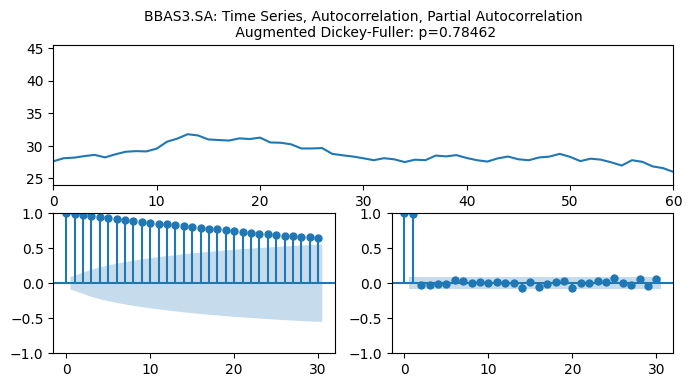

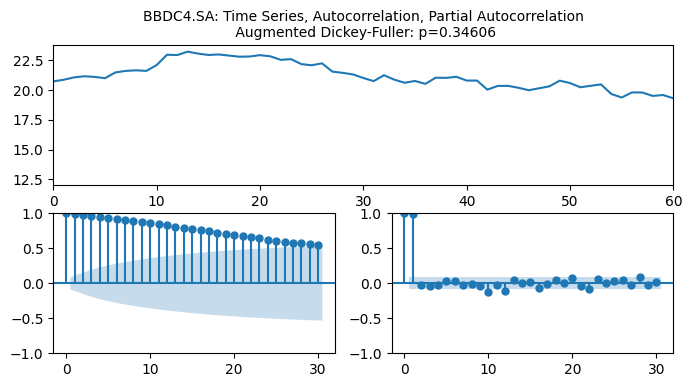

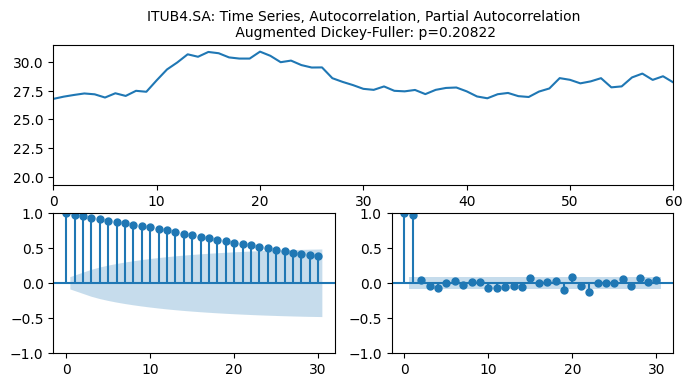

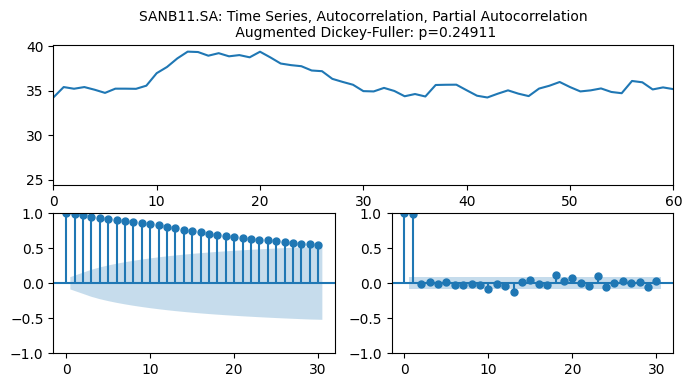

In [27]:
def tsplot(y, tickers, lags=None, figsize=(8, 4)):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    fig = plt.figure(figsize=figsize)
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_xlim(0, 60)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title(tickers + ": " + 'Time Series, Autocorrelation, Partial Autocorrelation\n Augmented Dickey-Fuller: p={0:.5f}'.format(p_value), fontsize=10)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, title="")
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, title="")
        
for i in tickers:
  tsplot(adj_close[i], lags=30, tickers=i)

The p-values of the augmented Dickey-Fuller tests tell us that we cannot reject the null hypothesis, i.e., that the series is non-stationary. We choose to perform first-order differentiation on the series so we can try to observe stationarity. 

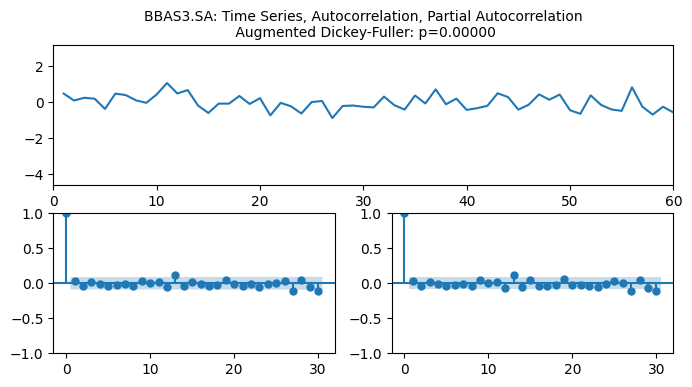

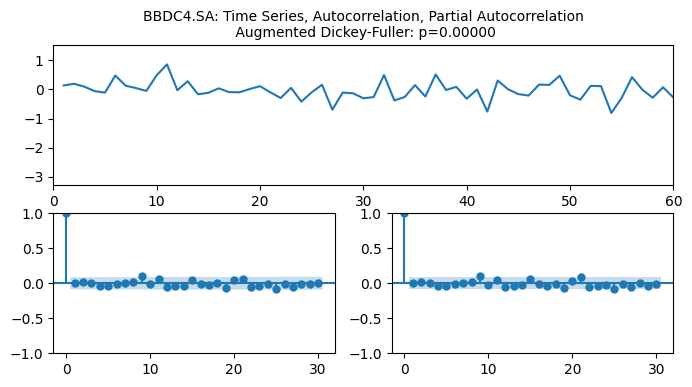

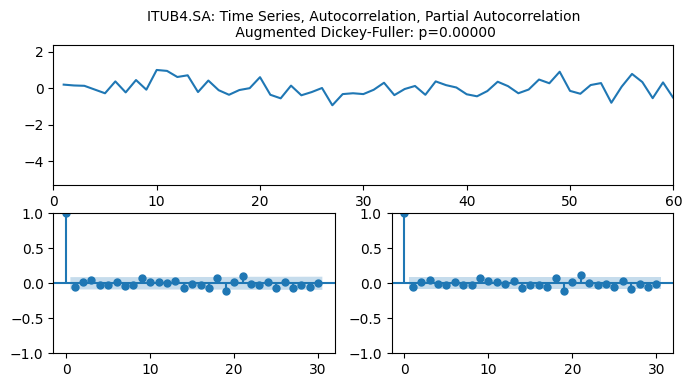

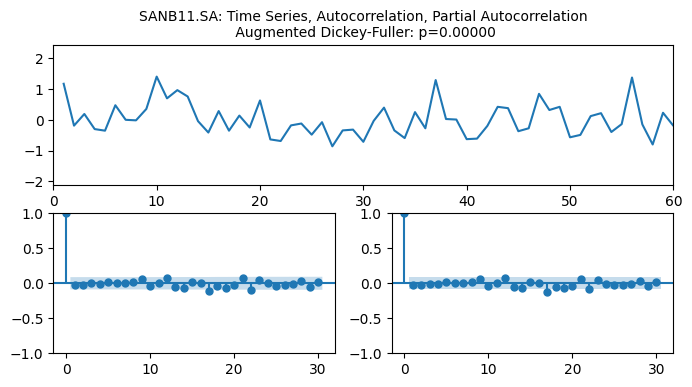

In [28]:
for i in tickers:
  tsplot(adj_close[i].diff().dropna(), lags=30, tickers=i)

**Modeling with ARIMA**

As the time series can be considered stationary after first-order differentiation, the d parameter (I - integration) of the ARIMA(p,d,q) model shall be 1. Also, for all the analyzed stocks, the autocorrelation and partial autocorrelation plots both show only the first lag being considerably out of the significance limit. We can then consider p=1 (AR - autoregression) and q=1 (MA - moving average). 

Testing Mean Squared Error:  0.6572505919401698


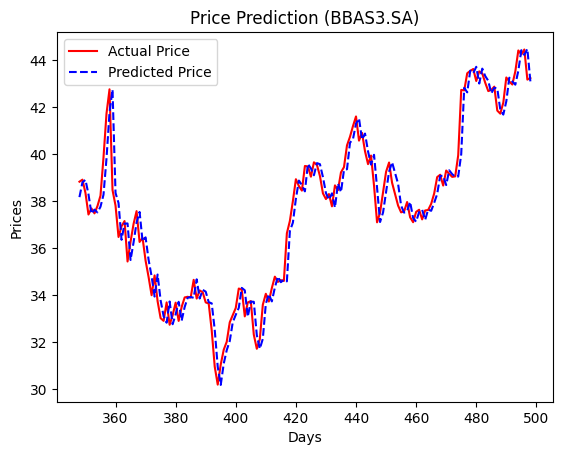

In [29]:
train_data, test_data = adj_close['BBAS3.SA'][0:int(len(adj_close['BBAS3.SA'])*0.7)], adj_close['BBAS3.SA'][int(len(adj_close['BBAS3.SA'])*0.7):]
training_data = train_data.values
test_data = test_data.values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error: ',  MSE_error)

test_set_range = adj_close['BBAS3.SA'][int(len(adj_close['BBAS3.SA'])*0.7):].index
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.plot(test_set_range, model_predictions, color='blue', linestyle='dashed',label='Predicted Price')
plt.title('Price Prediction (BBAS3.SA)')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

Testing Mean Squared Error:  0.16441905331184445


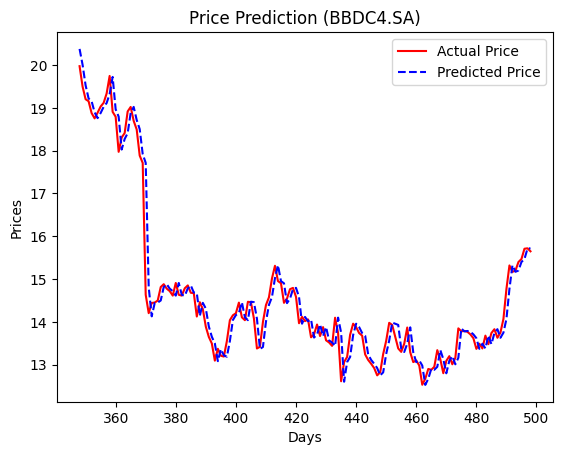

In [30]:
train_data, test_data = adj_close['BBDC4.SA'][0:int(len(adj_close['BBDC4.SA'])*0.7)], adj_close['BBDC4.SA'][int(len(adj_close['BBDC4.SA'])*0.7):]
training_data = train_data.values
test_data = test_data.values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error: ',  MSE_error)

test_set_range = adj_close['BBDC4.SA'][int(len(adj_close['BBDC4.SA'])*0.7):].index
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.plot(test_set_range, model_predictions, color='blue', linestyle='dashed',label='Predicted Price')
plt.title('Price Prediction (BBDC4.SA)')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

Testing Mean Squared Error:  0.23320269001871016


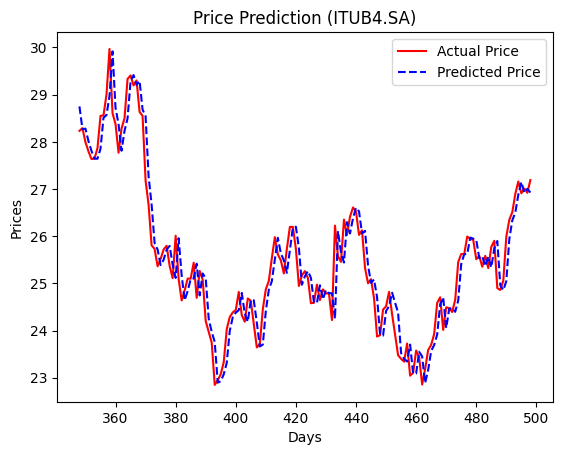

In [31]:
train_data, test_data = adj_close['ITUB4.SA'][0:int(len(adj_close['ITUB4.SA'])*0.7)], adj_close['ITUB4.SA'][int(len(adj_close['ITUB4.SA'])*0.7):]
training_data = train_data.values
test_data = test_data.values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error: ',  MSE_error)

test_set_range = adj_close['ITUB4.SA'][int(len(adj_close['ITUB4.SA'])*0.7):].index
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.plot(test_set_range, model_predictions, color='blue', linestyle='dashed',label='Predicted Price')
plt.title('Price Prediction (ITUB4.SA)')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

Testing Mean Squared Error:  0.267446746054466


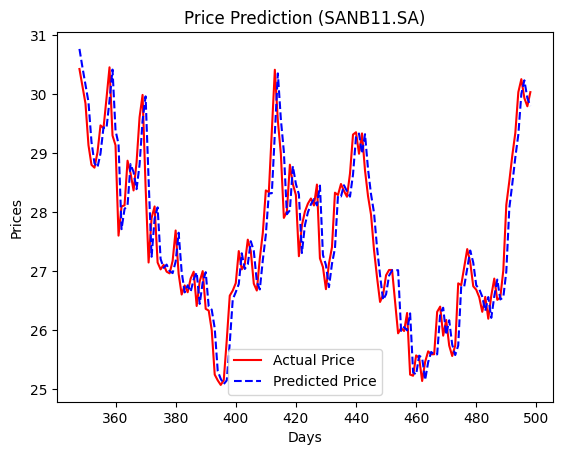

In [32]:
train_data, test_data = adj_close['SANB11.SA'][0:int(len(adj_close['SANB11.SA'])*0.7)], adj_close['SANB11.SA'][int(len(adj_close['SANB11.SA'])*0.7):]
training_data = train_data.values
test_data = test_data.values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error: ',  MSE_error)

test_set_range = adj_close['SANB11.SA'][int(len(adj_close['SANB11.SA'])*0.7):].index
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.plot(test_set_range, model_predictions, color='blue', linestyle='dashed',
         label='Predicted Price')
plt.title('Price Prediction (SANB11.SA)')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()